Homework 1

Name: Sudheeshna Sampath

Andrew ID: sudheess

In [1]:
#load necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
from matplotlib import dates as mpl_dates
import matplotlib as mpl
from matplotlib.ticker import LinearLocator, FuncFormatter

In [2]:
#read input file
df = pd.read_csv("C:\\Users\\sudhe\\Desktop\\Spring '22\\DSPM\\HW1\\HW1 clv_transactions.csv")

STEP 1

In [3]:
#Check if any column has missing values
print("Column TransactionID has missing values:", df['TransactionID'].isna().unique())
print("Column TransactionDate has missing values:", df['TransactionDate'].isna().unique())
print("Column CustomerID has missing values:",df['CustomerID'].isna().unique())
print("Column Amount has missing values:", df['Amount'].isna().unique())

Column TransactionID has missing values: [False]
Column TransactionDate has missing values: [False]
Column CustomerID has missing values: [False]
Column Amount has missing values: [False]


The dataset has no missing values

In [4]:
#Print earliest and latest transaction date
print("Latest Transaction Date:",df['TransactionDate'].max())
print("Earliest Transaction date:",df['TransactionDate'].min())

Latest Transaction Date: 9/9/2015
Earliest Transaction date: 1/1/2011


In [5]:
#Print Unique #Customers
print("Unique no.of customers:",len(df['CustomerID'].unique()))

Unique no.of customers: 1000


In [6]:
#Print Statistic info of data
print("Minimum Amount:" , df['Amount'].min())
print("Maximum Amount:" , df['Amount'].max())
print("Std. Deviation of Amount:" , stat.stdev(df['Amount']))
print("Variance of Amount:" , stat.variance(df['Amount']))

Minimum Amount: -1.0
Maximum Amount: 2033.0
Std. Deviation of Amount: 38.72390877418945
Variance of Amount: 1499.5411107517464


In [7]:
#Convert to appropriate datetime format and extract only Month-year from Transaction Date
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'],format='%m/%d/%Y')
df['TransMY']=pd.to_datetime(df['TransactionDate'].apply(lambda dt: dt.replace(day=1)))

#Calc Transaction Amount for Year-Month combination
df['TransactionAmtMY']= df.groupby(df['TransMY'])['Amount'].transform(sum)

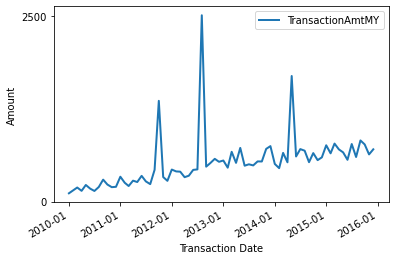

In [8]:
#Plot time series for Transaction Amount for Transaction Dates over Year-Month
df.plot(x='TransMY', y='TransactionAmtMY', lw=2)

date_format = mpl_dates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)

plt.rcParams.update({'font.size': 120})

plt.xlabel('Transaction Date', fontsize=10)
plt.ylabel('Amount', fontsize=10)
plt.show()

Except for the three outliers as found below, the above graph shows that there has been an infaltion in customer transaction amount over the years

STEP 2

In [9]:
#Extract outliers - values that lie above or below 2.5*std dev of Transaction Amount
df[np.abs(df['Amount']-df['Amount'].mean()) >= (2.5*stat.stdev(df['Amount']))]

,TransactionID,TransactionDate,CustomerID,Amount,TransMY,TransactionAmtMY
23,24,2011-10-07,7,1003.0,2011-10-01,1356.82
211,212,2014-05-14,54,1027.0,2014-05-01,1691.25
4177,4178,2012-08-13,1000,2033.0,2012-08-01,2508.98


In [10]:
#Negative Transaction Amounts  - since amount transacted has to be zero or more
df[df['Amount']<0]

,TransactionID,TransactionDate,CustomerID,Amount,TransMY,TransactionAmtMY
49,50,2012-05-12,13,-1.0,2012-05-01,348.88
3326,3327,2014-01-16,811,-1.0,2014-01-01,507.58


There are 3 records that are outliers and 2 that are negative. We can treat them by removing them from the dataset

In [11]:
#Remove outliers
df = df[np.abs(df['Amount']-df['Amount'].mean()) <= (2.5*stat.stdev(df['Amount']))]
df = df[df['Amount']>=0]

STEP 3

In [12]:
#remove unecessary columns
df = df.drop(['TransMY','TransactionAmtMY'],axis=1)

#Calc Earliest Transaction Date for each customer and find Origin Year
df['EarliestCustomerTransactionDt']= df.groupby(['CustomerID'])['TransactionDate'].transform(min)
df['Origin_1']=pd.to_datetime(df['EarliestCustomerTransactionDt']).apply(lambda dt: dt.replace(day=1,month=1))
df['Origin_2']=pd.to_datetime(df['EarliestCustomerTransactionDt']).apply(lambda dt: dt.replace(day=31,month=12))
df['Origin'] = df['Origin_1'].astype(str)+' - '+df['Origin_2'].astype(str)

In [13]:
#Calc Age column based on the difference in Transaction Date and Origin Year
new_df = df
new_df['Monthdifference'] = (df['TransactionDate']-df['Origin_1']).dt.days / 30

new_df['Age'] = 12*round(new_df['Monthdifference']/12)
new_df['Age'] = new_df['Age'].replace(0,12)
new_df = new_df.drop(['Monthdifference','EarliestCustomerTransactionDt','Origin_1','Origin_2'],axis=1)

In [14]:
#Calc Cumulative Transaction Amount by aggregating Transaction Amount on Origin and Age
new_df['Amt_cltv'] = new_df.groupby(['Origin','Age'])['Amount'].transform(sum)

cltv_amt_df = new_df[['Origin','Age','Amt_cltv']]
cltv_amt_df = cltv_amt_df.drop_duplicates()

#Pivot the dataframe to get cumulative Amount in required format
cltv_amt_df = cltv_amt_df.pivot(index='Origin', columns='Age', values='Amt_cltv')
cltv_amt_df = cltv_amt_df.cumsum(axis=1)
cltv_amt_df

Age,12.0,24.0,36.0,48.0,60.0,72.0
Origin,,,,,,
2010-01-01 - 2010-12-31,2951.55,4454.22,5908.71,7176.76,8416.45,8964.49
2011-01-01 - 2011-12-31,2898.98,4676.48,6064.11,7253.50,7862.24,NaN
2012-01-01 - 2012-12-31,2973.29,4566.49,5823.41,6501.85,NaN,NaN
2013-01-01 - 2013-12-31,2864.71,4313.27,5227.75,NaN,NaN,NaN
2014-01-01 - 2014-12-31,2575.32,3262.05,NaN,NaN,NaN,NaN
2015-01-01 - 2015-12-31,1912.17,NaN,NaN,NaN,NaN,NaN


In [15]:
#Calc Cumulative Transaction Amount by adding unique Customers per Origin and Age

new_df['customer_cltv'] = new_df.groupby(['Origin'])['CustomerID'].transform('nunique')

cltv_cust_df = new_df[['Origin','Age','customer_cltv']]
cltv_cust_df = cltv_cust_df.drop_duplicates()

#Pivot the dataframe to get cumulative # new Customers in required format
cltv_cust_df =cltv_cust_df.pivot(index='Origin', columns='Age', values='customer_cltv')
cltv_cust_df

Age,12.0,24.0,36.0,48.0,60.0,72.0
Origin,,,,,,
2010-01-01 - 2010-12-31,172.0,172.0,172.0,172.0,172.0,172.0
2011-01-01 - 2011-12-31,170.0,170.0,170.0,170.0,170.0,NaN
2012-01-01 - 2012-12-31,163.0,163.0,163.0,163.0,NaN,NaN
2013-01-01 - 2013-12-31,180.0,180.0,180.0,NaN,NaN,NaN
2014-01-01 - 2014-12-31,155.0,155.0,NaN,NaN,NaN,NaN
2015-01-01 - 2015-12-31,160.0,NaN,NaN,NaN,NaN,NaN


In [16]:
#Get historic cumulative amount from the above two pivots
clv_historic = cltv_amt_df/cltv_cust_df
clv_historic

Age,12.0,24.0,36.0,48.0,60.0,72.0
Origin,,,,,,
2010-01-01 - 2010-12-31,17.160174,25.896628,34.352965,41.725349,48.932849,52.119128
2011-01-01 - 2011-12-31,17.052824,27.508706,35.671235,42.667647,46.248471,NaN
2012-01-01 - 2012-12-31,18.241043,28.015276,35.726442,39.888650,NaN,NaN
2013-01-01 - 2013-12-31,15.915056,23.962611,29.043056,NaN,NaN,NaN
2014-01-01 - 2014-12-31,16.614968,21.045484,NaN,NaN,NaN,NaN
2015-01-01 - 2015-12-31,11.951062,NaN,NaN,NaN,NaN,NaN


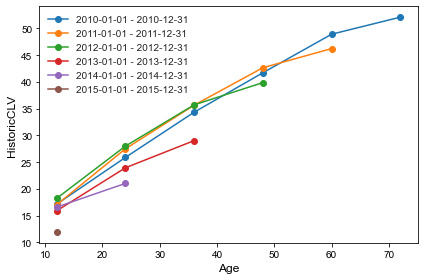

In [17]:
#plot Age vs. Historic Amt Cmltv for each Origin Year

for i,c in clv_historic.iterrows():
        plt.plot(clv_historic.columns,c.values,label=i,marker='o')
        
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 10})

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('Age', fontsize=12)
plt.ylabel('HistoricCLV', fontsize=12)
plt.legend(clv_historic.index,loc="upper left")
plt.tight_layout()
plt.show()

 - How much have customers acquired in 2011 spent to date?

Ans: 46.24$
    
- Do each group of customers exhibit similar or different patterns of spending? What’s the implication for the business?

Ans: Each group has a similar patter of spending. With each passing year, the cumulative transaction amount per customer group increases steadily. In first year they seem to spend 11$-17$, second 21$-25$, third 29$-35$, fourth 39$-42$, fifth 46$-48$ and last 52$. This shows that their spending pattern, although for people with earlier origin years spend more than the later ones, are similar.